In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Trajectory and output paths
n_H2O = 130
n_H3O = 4
temperature_K = 400
sampling = 2  #fs

TRAJ = Path.home() / f"master_thesis_project/Trajectories/xyz_MOF/MD_{n_H2O}H2O/MD_{n_H2O-n_H3O}H2O_{n_H3O}H3O_{temperature_K}K_{sampling}fs_traj.xyz"
OUT = Path.home() / "master_thesis_project/LionAnalysis/test"
OUT.mkdir(exist_ok=True)

In [2]:
# Get solvent indices from trajectory
with open(TRAJ) as f:
    n_atoms = int(f.readline().strip())
n_water = (n_H2O - n_H3O) * 3 + n_H3O * 4
n_mof = n_atoms - n_water
SOLVENT = " ".join(str(i) for i in range(n_mof + 1, n_atoms + 1))
print(f"Total: {n_atoms}, MOF: {n_mof}, Solvent: {n_water}")

Total: 826, MOF: 432, Solvent: 394


In [3]:
# Base config
MAX_TIMESTEP = 50000  # Frames limit for quick testing
STRIDE = 1  # Frame stride for analysis
STABLE_TIME_FS = 200  # Time (fs) to be considered "stable" hydronium

BASE_CONFIG = f"""
DumpFile {TRAJ}
DumpFileFormat mattixyz
Threads 16
Overwrite
CoutFrequency 500
IntelligentUnwrap
BasicTimeUnit {sampling/1000} # ps
SuperEvery {STRIDE}
Prefix {OUT}/
MaxTimestep {MAX_TIMESTEP if MAX_TIMESTEP else "inf"}
Const StableTime {STABLE_TIME_FS // sampling // STRIDE}
 
# --- Atom Groups ---
DefineGroup H ATOMICNUMBER H
DefineGroup O ATOMICNUMBER O
DefineGroup Zr ATOMICNUMBER Zr
DefineGroup C ATOMICNUMBER C

# --- Solvent and MOF Groups ---
DefineGroup Solvent LIST {SOLVENT}
DefineGroup Mof DIFF All Solvent

# --- Coordinated O Groups ---
DefineGroup SuperO FINDSHORTEST FromGroup H ToGroup O
DefineGroup O_H BOND O H MaxDist 1.25
ModifyGroup SuperO INTERSECTION SuperO O_H

DefineGroup SolventO INTERSECTION O Solvent
DefineGroup SolventO_H INTERSECTION SuperO SolventO
ModifyGroup SolventO_H SUM SolventO_H SolventO
DefineGroup MofO INTERSECTION O Mof
DefineGroup MofO_H INTERSECTION SuperO MofO
ModifyGroup MofO_H SUM MofO_H MofO

# --- Coordinated H Groups ---
DefineGroup SolventH INTERSECTION H Solvent
DefineGroup SuperH_O INVERTCOORDINATION SuperO
DefineGroup SolventH_O INVERTCOORDINATION SolventO_H
DefineGroup MofH INTERSECTION H Mof
DefineGroup MofH_O INVERTCOORDINATION MofO_H

# --- Coordinated Solvent O Groups ---
DefineGroup HydroniumO_H SUBGROUPCN SolventO_H Coord 3
DefineGroup WaterO_H SUBGROUPCN SolventO_H Coord 2
DefineGroup HydroxideO_H SUBGROUPCN SolventO_H Coord 1
DefineGroup RadicalO SUBGROUPCN SolventO_H Coord 0

# --- Coordinated Solvent H Groups ---
DefineGroup HydroniumH_O INVERTCOORDINATION HydroniumO_H
DefineGroup WaterH_O INVERTCOORDINATION WaterO_H
DefineGroup HydroxideH_O INVERTCOORDINATION HydroxideO_H
DefineGroup RadicalH SUBGROUPCN SolventH_O Coord 0

# --- Stable Solvent O groups ---
# MaxHistory = MinMemberTime → must be hydronium for ALL of last 500fs
DefineGroup StableHydroniumO MEMBERHISTORY \
    ParentGroup SolventO_H MemberOf HydroniumO_H DrawFrom HydroniumO_H \
    MaxHistory StableTime MinMemberTime StableTime

# --- Coordinated linker Groups ---
DefineGroup LinkerO_CH BOND MofO_H C MaxDist 1.6
DefineGroup LinkerCH_O INVERTCOORDINATION LinkerO_CH
DefineGroup LinkerC_O INTERSECTION LinkerCH_O C
DefineGroup LinkerH_O INTERSECTION LinkerCH_O H

# --- Coordinated mu3 Groups ---
DefineGroup Mu3O_H DIFF MofO_H LinkerO_CH
DefineGroup Mu3H_O INVERTCOORDINATION Mu3O_H
"""

In [4]:
import subprocess

def run(config=""):
    """Write config and run lionanalysis."""
    cfg = OUT / "test.config"
    full_config = BASE_CONFIG + config + "\nAverageSize\n"
    cfg.write_text(full_config)
    
    subprocess.run(["lionanalysis.exe", str(cfg)])
    
    # Show group sizes
    avgsize = OUT / "averagesize.dat"
    if avgsize.exists():
        print("\n=== Group Sizes ===")
        print(avgsize.read_text())

# Test base config
# run("")

## PTFEL Water

In [ ]:
config_ptfel_water = ("""
HydrogenBond SolventO_H SolventO_H SolventH_O \
    CopyGroup1 AcceptorO NewGroup1CoordinationGroup 3 \
    CopyGroup2 DonorO NewGroup2CoordinationGroup 1 \
    CopyGroup3 DonorH NewGroup3CoordinationGroup 1

DoubleCoordinationShortDelta Filename ptfel_water \
    LHS AcceptorO SolventH_O LGroup3MustBe DonorO \
    RHS AcceptorO SolventH_O RGroup3MustBe DonorO \
    Every 1 MinValue 0 MaxValue 1.5 Resolution 0.01 \
    Min13 2.0 Max13 3.5 Resolution13 0.01 WellAtZero
""")

## PTFEL MOF

In [14]:
config_ptfel_mof=("""
# MOF-Solvent h-bond groups (for MOF PTFEL)

# H-bond: MOF O (acceptor) < H < Solvent O (donor)
HydrogenBond MofO_H SolventO_H SolventH_O \
    CopyGroup1 MofAcceptorO NewGroup1CoordinationGroup 3 \
    CopyGroup2 SolventDonorO NewGroup2CoordinationGroup 1 \
    CopyGroup3 SolventDonorH NewGroup3CoordinationGroup 1

# H-bond: Solvent O (acceptor) < H < MOF O (donor)
HydrogenBond SolventO_H MofO_H MofH_O \
    CopyGroup1 SolventAcceptorO NewGroup1CoordinationGroup 3 \
    CopyGroup2 MofDonorO NewGroup2CoordinationGroup 1 \
    CopyGroup3 MofDonorH NewGroup3CoordinationGroup 1

# Create combined H group with O coordination for DCSD Group2
DefineGroup AllH SUM SolventH MofH
DefineGroup AllO SUM MofO SolventO
DefineGroup AllO_H FINDSHORTEST FromGroup AllH ToGroup AllO
DefineGroup AllH_O INVERTCOORDINATION AllO_H

# CRITICAL: For DCSD, Group1 needs coordination matching Group2 (AllH_O)
# Use INTERSECTION+SUM pattern to give acceptor groups AllO_H coordination
DefineGroup MofAcceptorO_AllH INTERSECTION AllO_H MofAcceptorO
ModifyGroup MofAcceptorO_AllH SUM MofAcceptorO_AllH MofAcceptorO

DefineGroup SolventAcceptorO_AllH INTERSECTION AllO_H SolventAcceptorO
ModifyGroup SolventAcceptorO_AllH SUM SolventAcceptorO_AllH SolventAcceptorO

# MOF-Solvent proton transfer: MOF_O < H > SolventO
# LHS (δ>0): H closer to water donor, MOF is acceptor
# RHS (δ<0): H closer to MOF donor, water is acceptor
DoubleCoordinationShortDelta Filename ptfel_mof \
    LHS MofAcceptorO_AllH AllH_O LGroup3MustBe SolventDonorO \
    RHS SolventAcceptorO_AllH AllH_O RGroup3MustBe MofDonorO \
    Every 1 MinValue 0.0 MaxValue 2 Resolution 0.01 \
    Min13 2.0 Max13 3.5 Resolution13 0.01 WellAtZero
""")

run(config_ptfel_water + config_ptfel_mof)

DumpFile /home/luc/master_thesis_project/Trajectories/xyz_MOF/MD_130H2O/MD_126H2O_4H3O_400K_2fs_traj.xyz
DumpFileFormat mattixyz
Threads 16
Overwrite
CoutFrequency 10
IntelligentUnwrap
BasicTimeUnit 0.002 # ps
SuperEvery 1
Prefix /home/luc/master_thesis_project/LionAnalysis/test/
MaxTimestep 100000
Const StableTime 100
DefineGroup H ATOMICNUMBER H
DefineGroup O ATOMICNUMBER O
DefineGroup Zr ATOMICNUMBER Zr
DefineGroup C ATOMICNUMBER C
DefineGroup Solvent LIST 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 

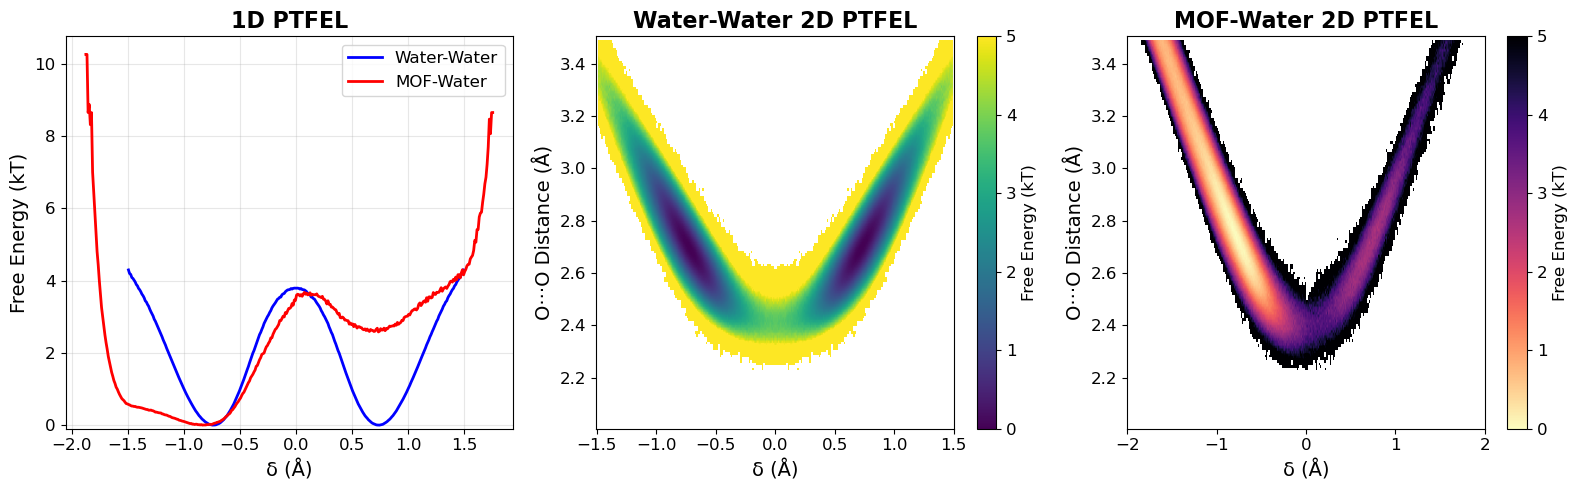

In [10]:
# Plot PTFEL Water and MOF (1D and 2D)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Font sizes for publication
TITLE_SIZE = 16
LABEL_SIZE = 14
TICK_SIZE = 12
LEGEND_SIZE = 12
CBAR_SIZE = 12

# 1D PTFEL
ax = axes[0]
A_water = np.loadtxt(OUT / "ptfel_water")
y_water = A_water[:, 1] - np.min(A_water[:, 1])
ax.plot(A_water[:, 0], y_water, 'b-', label="Water-Water", linewidth=2)

A_mof = np.loadtxt(OUT / "ptfel_mof")
y_mof = A_mof[:, 1] - np.min(A_mof[:, 1])
ax.plot(A_mof[:, 0], y_mof, 'r-', label="MOF-Water", linewidth=2)

ax.set_xlabel("δ (Å)", fontsize=LABEL_SIZE)
ax.set_ylabel("Free Energy (kT)", fontsize=LABEL_SIZE)
ax.set_title("1D PTFEL", fontsize=TITLE_SIZE, fontweight='bold')
ax.set_ylim(-0.1, max(y_water[y_water != np.inf].max(), y_mof[y_mof != np.inf].max()) + 0.5)
ax.legend(fontsize=LEGEND_SIZE)
ax.tick_params(axis='both', labelsize=TICK_SIZE)
ax.grid(True, alpha=0.3)

# 2D PTFEL Water
ax = axes[1]
A_water_2d = np.loadtxt(OUT / "ptfel_water2d")
delta = A_water_2d[:, 0]
oo_dist = A_water_2d[:, 1]
fe = A_water_2d[:, 2]

# Get unique values for reshaping
delta_unique = np.unique(delta)
oo_unique = np.unique(oo_dist)
n_delta, n_oo = len(delta_unique), len(oo_unique)

# Reshape to 2D grid
fe_grid = fe.reshape(n_delta, n_oo).T
fe_grid = np.where(np.isinf(fe_grid), np.nan, fe_grid)
fe_grid = fe_grid - np.nanmin(fe_grid)

im = ax.imshow(fe_grid, origin='lower', aspect='auto',
               extent=[delta_unique.min(), delta_unique.max(), oo_unique.min(), oo_unique.max()],
               cmap='viridis', vmin=0, vmax=5)
ax.set_xlabel("δ (Å)", fontsize=LABEL_SIZE)
ax.set_ylabel("O···O Distance (Å)", fontsize=LABEL_SIZE)
ax.set_title("Water-Water 2D PTFEL", fontsize=TITLE_SIZE, fontweight='bold')
ax.tick_params(axis='both', labelsize=TICK_SIZE)
cbar = plt.colorbar(im, ax=ax, label="Free Energy (kT)")
cbar.ax.tick_params(labelsize=TICK_SIZE)
cbar.set_label("Free Energy (kT)", fontsize=CBAR_SIZE)

# 2D PTFEL MOF
ax = axes[2]
A_mof_2d = np.loadtxt(OUT / "ptfel_mof2d")
delta = A_mof_2d[:, 0]
oo_dist = A_mof_2d[:, 1]
fe = A_mof_2d[:, 2]

delta_unique = np.unique(delta)
oo_unique = np.unique(oo_dist)
n_delta, n_oo = len(delta_unique), len(oo_unique)

fe_grid = fe.reshape(n_delta, n_oo).T
fe_grid = np.where(np.isinf(fe_grid), np.nan, fe_grid)
fe_grid = fe_grid - np.nanmin(fe_grid)

im = ax.imshow(fe_grid, origin='lower', aspect='auto',
               extent=[delta_unique.min(), delta_unique.max(), oo_unique.min(), oo_unique.max()],
               cmap='magma_r', vmin=0, vmax=5)
ax.set_xlabel("δ (Å)", fontsize=LABEL_SIZE)
ax.set_ylabel("O···O Distance (Å)", fontsize=LABEL_SIZE)
ax.set_title("MOF-Water 2D PTFEL", fontsize=TITLE_SIZE, fontweight='bold')
ax.tick_params(axis='both', labelsize=TICK_SIZE)
cbar = plt.colorbar(im, ax=ax, label="Free Energy (kT)")
cbar.ax.tick_params(labelsize=TICK_SIZE)
cbar.set_label("Free Energy (kT)", fontsize=CBAR_SIZE)

plt.tight_layout()

## Proton Hops

In [13]:
# Get hop coordinates using LionAnalysis using WhenGroupChangedDefineGroup + PrintProperties

config_hop_coords = """
# Track ALL proton hop events (no MinReactantTime = include rattling)
# WhenGroupChangedDefineGroup defines group with Id X
# ChangeGroupTime calls that action via Action X

# Define the groups that will be populated by ChangeGroupTime
WhenGroupChangedDefineGroup HopDonor Id 1
WhenGroupChangedDefineGroup HopAcceptor Id 2

# H3O+ → H2O hops (donor loses proton) - calls Action 1
ChangeGroupTime Reactants HydroniumO_H Products WaterO_H \
    Filename hop_all_h3o_to_h2o \
    ParentGroup SolventO_H \
    Action 1

# H2O → H3O+ hops (acceptor gains proton) - calls Action 2
ChangeGroupTime Reactants WaterO_H Products HydroniumO_H \
    Filename hop_all_h2o_to_h3o \
    ParentGroup SolventO_H \
    Action 2

# Print coordinates of hop events (timestep, numatoms, then id x y z per atom)
PrintProperties hop_donor_coords Every 1 MultipleLines  \
    GROUPS HopDonor \
    PROPERTIES timestepiteration numatoms id type x y z

PrintProperties hop_acceptor_coords Every 1 MultipleLines  \
    GROUPS HopAcceptor \
    PROPERTIES timestepiteration numatoms id type x y z
"""

# run(config_hop_coords)

H3O+→H2O: 1848 hops, mean residence: 764.9 fs
H2O→H3O+: 12351 hops, mean residence: 1053.7 fs


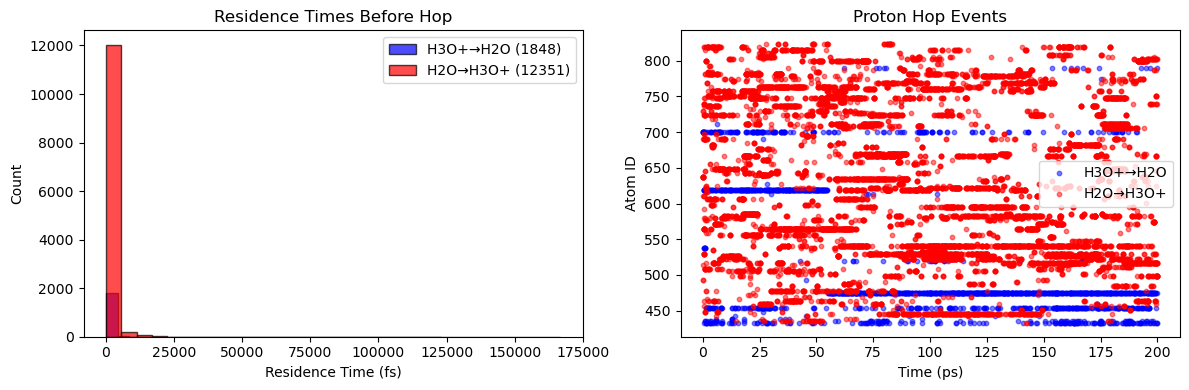

In [18]:
# Plot proton hop events
hop_file_out = OUT / "hop_h3o_to_h2o"  # H3O+ → H2O (proton leaving)
hop_file_in = OUT / "hop_h2o_to_h3o"   # H2O → H3O+ (proton arriving)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

has_data = False

# H3O+ → H2O hops (blue)
if hop_file_out.exists() and hop_file_out.stat().st_size > 0:
    df_out = pd.read_csv(hop_file_out, sep=r"\s+", header=None,
                         names=["atom_id", "first_in", "last_in", "last_as", "first_product"])
    df_out["residence_fs"] = (df_out["last_as"] - df_out["first_in"]) * STRIDE * sampling
    
    axes[0].hist(df_out["residence_fs"], bins=30, edgecolor='black', alpha=0.7, 
                 label=f"H3O+→H2O ({len(df_out)})", color='blue')
    axes[1].scatter(df_out["first_product"] * STRIDE * sampling / 1000, 
                    df_out["atom_id"], s=10, alpha=0.5, c='blue', label="H3O+→H2O")
    has_data = True
    print(f"H3O+→H2O: {len(df_out)} hops, mean residence: {df_out['residence_fs'].mean():.1f} fs")

# H2O → H3O+ hops (red)
if hop_file_in.exists() and hop_file_in.stat().st_size > 0:
    df_in = pd.read_csv(hop_file_in, sep=r"\s+", header=None,
                        names=["atom_id", "first_in", "last_in", "last_as", "first_product"])
    df_in["residence_fs"] = (df_in["last_as"] - df_in["first_in"]) * STRIDE * sampling
    
    axes[0].hist(df_in["residence_fs"], bins=30, edgecolor='black', alpha=0.7,
                 label=f"H2O→H3O+ ({len(df_in)})", color='red')
    axes[1].scatter(df_in["first_product"] * STRIDE * sampling / 1000,
                    df_in["atom_id"], s=10, alpha=0.5, c='red', label="H2O→H3O+")
    has_data = True
    print(f"H2O→H3O+: {len(df_in)} hops, mean residence: {df_in['residence_fs'].mean():.1f} fs")

if has_data:
    axes[0].set_xlabel("Residence Time (fs)")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Residence Times Before Hop")
    axes[0].legend()
    
    axes[1].set_xlabel("Time (ps)")
    axes[1].set_ylabel("Atom ID")
    axes[1].set_title("Proton Hop Events")
    axes[1].legend()
    
    plt.tight_layout()
else:
    print("No hop events recorded (MinReactantTime may be too long)")

Extracting transfer positions from trajectory...
  Loading donor positions (H3O+ → H2O)...
  Processed 50/50 frames (257.8s, ETA: 0.0s)))
  Loading acceptor positions (H2O → H3O+)...
  Processed 50/50 frames (219.9s, ETA: 0.0s)))
Extraction complete in 477.7s
Saved positions to transfer_positions.npz
Total: 100 transfer positions


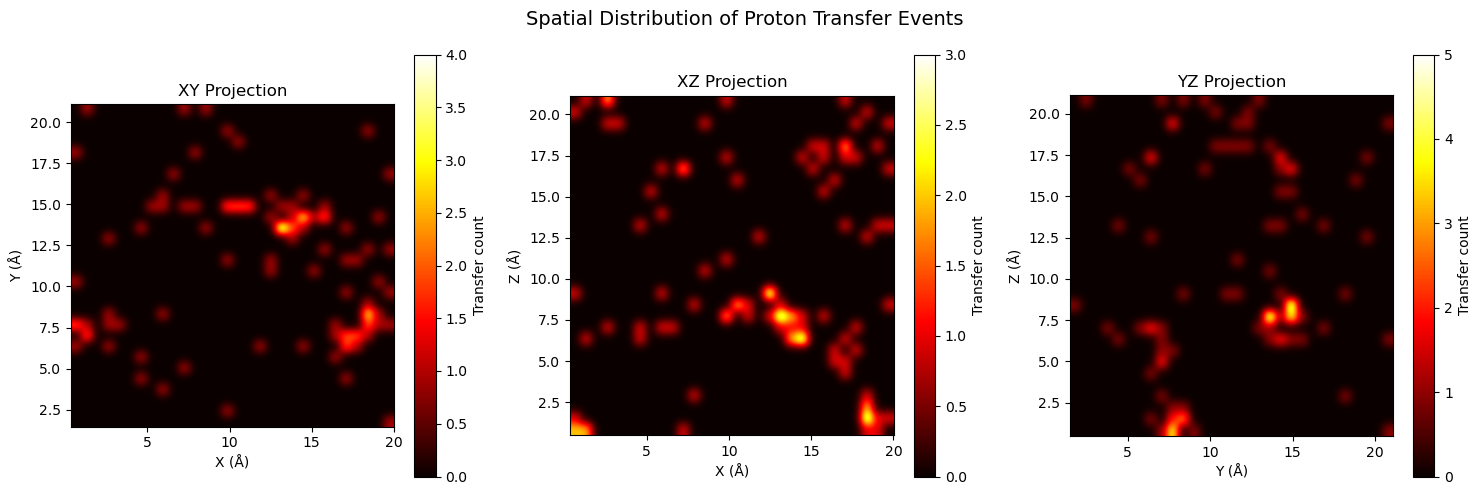

In [5]:
# Spatial Proton Transfer Heatmap
# Extract coordinates from trajectory at transfer timesteps
import time

POSITIONS_FILE = OUT / "transfer_positions.npz"
MAX_SAMPLES = 50  # Max samples per hop type

def read_frame_coords(traj_path, frame_idx, n_atoms):
    """Read coordinates from a specific frame in XYZ trajectory."""
    lines_per_frame = n_atoms + 2  # natoms + comment + coords
    
    with open(traj_path, 'r') as f:
        # Skip to target frame
        for _ in range(frame_idx * lines_per_frame):
            f.readline()
        
        # Read frame
        f.readline()  # n_atoms
        f.readline()  # comment
        
        coords = {}
        for i in range(1, n_atoms + 1):
            parts = f.readline().split()
            if len(parts) >= 4:
                coords[i] = np.array([float(parts[1]), float(parts[2]), float(parts[3])])
    return coords

def get_transfer_positions(hop_file, traj_path, n_atoms, max_frames=1000):
    """Get 3D positions where proton transfers occurred."""
    if not hop_file.exists() or hop_file.stat().st_size == 0:
        return np.array([])
    
    df = pd.read_csv(hop_file, sep=r"\s+", header=None,
                     names=["atom_id", "first_in", "last_in", "last_as", "first_product"])
    
    # Sample if too many events
    if len(df) > max_frames:
        df = df.sample(n=max_frames, random_state=42)
    
    positions = []
    t0 = time.time()
    total = len(df)
    
    for idx, (_, row) in enumerate(df.iterrows()):
        frame = int(row["first_product"])
        atom_id = int(row["atom_id"])
        
        try:
            coords = read_frame_coords(traj_path, frame, n_atoms)
            if atom_id in coords:
                positions.append(coords[atom_id])
        except:
            continue
        
        elapsed = time.time() - t0
        rate = (idx + 1) / elapsed if elapsed > 0 else 0
        eta = (total - idx - 1) / rate if rate > 0 else 0
        print(f"\r  Processed {idx+1}/{total} frames ({elapsed:.1f}s, ETA: {eta:.1f}s)", end="", flush=True)
    
    print()  # newline
    return np.array(positions)

# Check if cached data exists
if POSITIONS_FILE.exists():
    print(f"Loading cached positions from {POSITIONS_FILE.name}...")
    data = np.load(POSITIONS_FILE)
    pos_donor = data['pos_donor']
    pos_acceptor = data['pos_acceptor']
    print(f"Loaded {len(pos_donor)} donor + {len(pos_acceptor)} acceptor positions")
else:
    t_start = time.time()
    print("Extracting transfer positions from trajectory...")

    print("  Loading donor positions (H3O+ → H2O)...")
    pos_donor = get_transfer_positions(OUT / "hop_h3o_to_h2o", TRAJ, n_atoms, max_frames=MAX_SAMPLES)

    print("  Loading acceptor positions (H2O → H3O+)...")
    pos_acceptor = get_transfer_positions(OUT / "hop_h2o_to_h3o", TRAJ, n_atoms, max_frames=MAX_SAMPLES)

    t_extract = time.time() - t_start
    print(f"Extraction complete in {t_extract:.1f}s")
    
    # Save to file
    np.savez(POSITIONS_FILE, pos_donor=pos_donor, pos_acceptor=pos_acceptor)
    print(f"Saved positions to {POSITIONS_FILE.name}")

# Combine positions
all_positions = np.vstack([pos_donor, pos_acceptor]) if len(pos_donor) > 0 and len(pos_acceptor) > 0 else \
                pos_donor if len(pos_donor) > 0 else pos_acceptor

print(f"Total: {len(all_positions)} transfer positions")

if len(all_positions) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    projections = [
        ("XY", 0, 1, "X (Å)", "Y (Å)"),
        ("XZ", 0, 2, "X (Å)", "Z (Å)"),
        ("YZ", 1, 2, "Y (Å)", "Z (Å)")
    ]
    
    for ax, (name, i, j, xlabel, ylabel) in zip(axes, projections):
        # Create 2D histogram
        H, xedges, yedges = np.histogram2d(
            all_positions[:, i], all_positions[:, j],
            bins=30
        )
        
        im = ax.imshow(H.T, origin='lower', aspect='equal',
                       extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                       cmap='hot', interpolation='gaussian')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(f"{name} Projection")
        plt.colorbar(im, ax=ax, label="Transfer count")
    
    plt.suptitle("Spatial Distribution of Proton Transfer Events", fontsize=14)
    plt.tight_layout()
else:
    print("No positions extracted")

In [ ]:
# Parse PrintProperties output and create spatial heatmap

def parse_hop_coords(filepath):
    """Parse PrintProperties output with NewLineSeparator format.
    
    Format: Each line has either:
    - timestepiteration numatoms (when new timestep starts)  
    - id x y z (for each atom in the group at that timestep)
    
    With NewLineSeparator, each atom is on its own line.
    """
    if not filepath.exists() or filepath.stat().st_size == 0:
        return np.array([])
    
    positions = []
    with open(filepath) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 4:  # id x y z
                try:
                    x, y, z = float(parts[1]), float(parts[2]), float(parts[3])
                    positions.append([x, y, z])
                except ValueError:
                    continue
    
    return np.array(positions) if positions else np.array([])

# Load hop coordinates from LionAnalysis output
print("Loading hop coordinates from LionAnalysis...")
pos_donor_lion = parse_hop_coords(OUT / "hop_donor_coords")
pos_acceptor_lion = parse_hop_coords(OUT / "hop_acceptor_coords")

print(f"Donor hops (H3O+→H2O): {len(pos_donor_lion)} positions")
print(f"Acceptor hops (H2O→H3O+): {len(pos_acceptor_lion)} positions")

# Combine all positions
if len(pos_donor_lion) > 0 and len(pos_acceptor_lion) > 0:
    all_pos_lion = np.vstack([pos_donor_lion, pos_acceptor_lion])
elif len(pos_donor_lion) > 0:
    all_pos_lion = pos_donor_lion
elif len(pos_acceptor_lion) > 0:
    all_pos_lion = pos_acceptor_lion
else:
    all_pos_lion = np.array([])

print(f"Total hop positions: {len(all_pos_lion)}")

# Plot spatial heatmap
if len(all_pos_lion) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    projections = [
        ("XY", 0, 1, "X (Å)", "Y (Å)"),
        ("XZ", 0, 2, "X (Å)", "Z (Å)"),
        ("YZ", 1, 2, "Y (Å)", "Z (Å)")
    ]
    
    for ax, (name, i, j, xlabel, ylabel) in zip(axes, projections):
        H, xedges, yedges = np.histogram2d(
            all_pos_lion[:, i], all_pos_lion[:, j],
            bins=50
        )
        
        im = ax.imshow(H.T, origin='lower', aspect='equal',
                       extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                       cmap='hot', interpolation='gaussian')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(f"{name} Projection")
        plt.colorbar(im, ax=ax, label="Hop count")
    
    plt.suptitle("Spatial Distribution of ALL Proton Hops (incl. rattling)", fontsize=14)
    plt.tight_layout()
else:
    print("No hop coordinates found")

## RDF

In [14]:
rdf_config=("""
# --- RDFs Solvent-Solvent ---
RDF SolventO_H SolventH_O rdf_o_h MinDist 0.5 MaxDist 5.0 Resolution 0.05
RDF SolventO_H SolventO_H rdf_o_o MinDist 0.5 MaxDist 5.0 Resolution 0.05
    
# --- RDFs Mu3O-Solvent ---
RDF Mu3O_H SuperH_O rdf_mu3o_h MinDist 0.5 MaxDist 5.0 Resolution 0.05
RDF Mu3O_H SolventO_H rdf_mu3o_o MinDist 0.5 MaxDist 5.0 Resolution 0.05
        
# --- RDFs LinkerO-Solvent ---
RDF LinkerO_CH SuperH_O rdf_linkero_h MinDist 0.5 MaxDist 5.0 Resolution 0.05
RDF LinkerO_CH SolventO_H rdf_linkero_o MinDist 0.5 MaxDist 5.0 Resolution 0.05
""")

run(rdf_config)

DumpFile /home/luc/master_thesis_project/Trajectories/xyz_MOF/MD_130H2O/MD_126H2O_4H3O_400K_2fs_traj.xyz
DumpFileFormat mattixyz
Threads 16
Overwrite
CoutFrequency 10
IntelligentUnwrap
BasicTimeUnit 0.002 # ps
SuperEvery 1
Prefix /home/luc/master_thesis_project/LionAnalysis/test/
MaxTimestep 100000
Const StableTime 100
DefineGroup H ATOMICNUMBER H
DefineGroup O ATOMICNUMBER O
DefineGroup Zr ATOMICNUMBER Zr
DefineGroup C ATOMICNUMBER C
DefineGroup Solvent LIST 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 

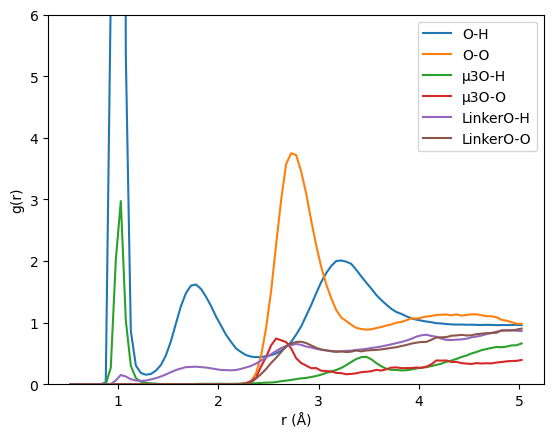

In [5]:
# Plot RDF
for f, label in [("rdf_o_h", "O-H"), ("rdf_o_o", "O-O"), 
                ("rdf_mu3o_h", "μ3O-H"), ("rdf_mu3o_o", "μ3O-O"),
                 ("rdf_linkero_h", "LinkerO-H"), ("rdf_linkero_o", "LinkerO-O")]:
    df = pd.read_csv(OUT / f"{f}", sep=r"\s+")
    plt.plot(df.iloc[:, 0], df.iloc[:, 1], label=label)
    plt.ylim(0, 6)
plt.xlabel("r (Å)"); plt.ylabel("g(r)"); plt.legend();

## H-bonds

In [ ]:
run("""
HydrogenBond Mu3O_H SolventO_H SolventH_O Filename hbond_mu3o_h
HydrogenBond SolventO_H Mu3O_H Mu3H_O Filename hbond_mu3h_o
""")

DumpFile /home/luc/master_thesis_project/Trajectories/xyz_MOF/MD_130H2O/MD_126H2O_4H3O_400K_2fs_traj.xyz
DumpFileFormat mattixyz
Threads 16
Overwrite
CoutFrequency 10
IntelligentUnwrap
BasicTimeUnit 0.002 # ps
SuperEvery 5
Prefix /home/luc/master_thesis_project/LionAnalysis/test/
MaxTimestep 10000
Const StableTime 20
DefineGroup H ATOMICNUMBER H
DefineGroup O ATOMICNUMBER O
DefineGroup Zr ATOMICNUMBER Zr
DefineGroup C ATOMICNUMBER C
DefineGroup Solvent LIST 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 56

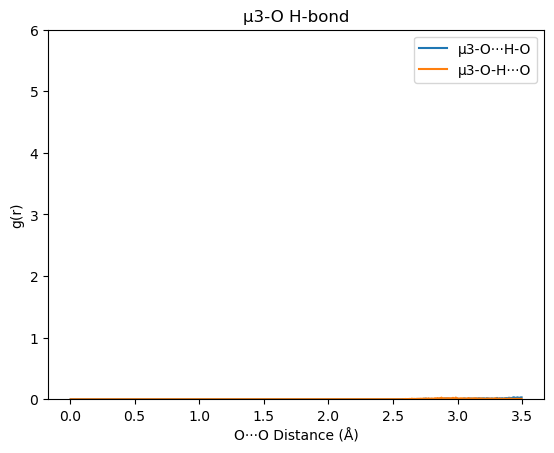

In [ ]:
# Plot H-bond RDF (file _4 = O...O distance summed over angles)
for f, label in [("hbond_mu3o_h_4", "μ3-O···H-O"), ("hbond_mu3h_o_4", "μ3-O-H···O")]:
    df = pd.read_csv(OUT / f"{f}", sep=r"\s+")
    plt.plot(df.iloc[:, 0], df.iloc[:, 1], label=label)
    plt.ylim(0, 6)
plt.xlabel("O···O Distance (Å)"); plt.ylabel("g(r)"); plt.legend(); plt.title("μ3-O H-bond");

## MSD

In [68]:
# Calculate trajectory time in ps
n_frames = MAX_TIMESTEP // STRIDE if MAX_TIMESTEP else 10000
traj_time_ps = n_frames * STRIDE * sampling / 1000  # fs to ps

run(f"""
# Vehicular MSD: track actual physical displacement of H3O+ oxygens
# - NewMemberEscape1 -1 0 0 VR: if NOT continuously member t0→dt → add 0 (no transfer)
TMSDFollow ParentGroup SolventO_H Group HydroniumO_H Filename msd_vehicular_VR5 \
    MaxHistory {traj_time_ps:.1f} RealTime PrintEvery 500 \
    NewMemberEscape1 -1 5 -1 VR @
TMSDFollow ParentGroup SolventO_H Group HydroniumO_H Filename msd_vehicular_UR5 \
    MaxHistory {traj_time_ps:.1f} RealTime PrintEvery 500 \
    NewMemberEscape1 -1 5 -1 UR @

# Structural MSD: track charge displacement (Grotthuss mechanism)
TMSDFollow ParentGroup SolventH Group HydroniumH_O Filename msd_structural \
    MaxHistory {traj_time_ps:.1f} RealTime PrintEvery 500 \
    NewMemberEscape1 -1 5 -1 VR @
""")

DumpFile /home/luc/master_thesis_project/Trajectories/xyz_MOF/MD_130H2O/MD_126H2O_4H3O_400K_2fs_traj.xyz
DumpFileFormat mattixyz
Threads 16
Overwrite
CoutFrequency 500
IntelligentUnwrap
BasicTimeUnit 0.002 # ps
SuperEvery 1
Prefix /home/luc/master_thesis_project/LionAnalysis/test/
MaxTimestep 50000
Const StableTime 100
DefineGroup H ATOMICNUMBER H
DefineGroup O ATOMICNUMBER O
DefineGroup Zr ATOMICNUMBER Zr
DefineGroup C ATOMICNUMBER C
DefineGroup Solvent LIST 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 

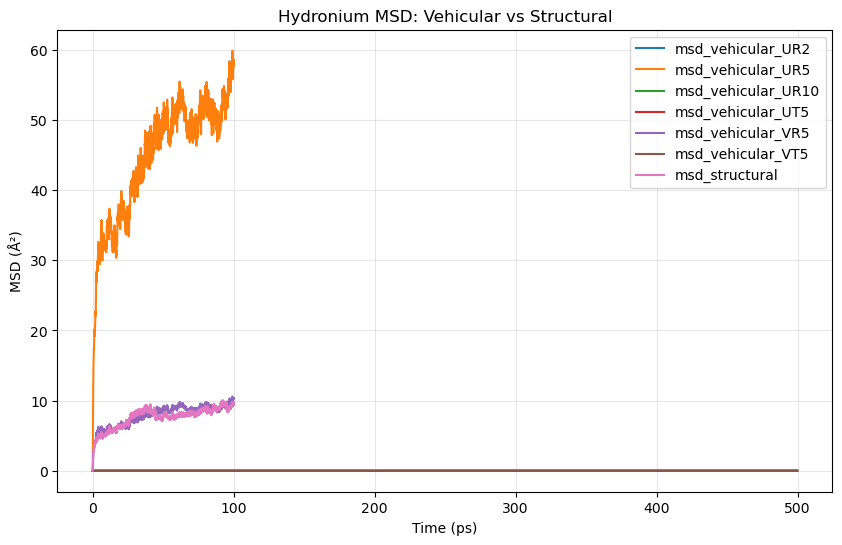

In [69]:
def msd2df(filename):
    """Read MSD file to DataFrame."""
    try:
        df = pd.read_csv(filename, sep=r"\s+", skiprows=2, header=0, engine="python")
    except pd.errors.EmptyDataError:
        return pd.DataFrame(columns=["#t(ps)", "value", "sum", "count"]) 

    df.columns = [str(c).strip() for c in df.columns]
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    if "#t(ps)" in df.columns:
        df = df.dropna(subset=["#t(ps)"])
        df = df.sort_values(by="#t(ps)")
    return df

plt.figure(figsize=(10, 6))

# Plot vehicular MSD
for file in ["msd_vehicular_UR2", "msd_vehicular_UR5", "msd_vehicular_UR10", 
             "msd_vehicular_UT5", "msd_vehicular_VR5", "msd_vehicular_VT5", "msd_structural"]:
    df = msd2df(OUT / file)
    if not df.empty:
        plt.plot(df["#t(ps)"], df["value"], label=file)
plt.xlabel("Time (ps)")
plt.ylabel("MSD (Å²)")
plt.title("Hydronium MSD: Vehicular vs Structural")
plt.legend()
plt.grid(True, alpha=0.3)